In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.utils.vis_utils import plot_model
import sklearn
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import math
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
#from tensorflow import set_random_seed
from numpy.random import seed
#set_random_seed(1)
seed(1)

train = pd.read_csv('../data/train_full.csv',',')

train.describe()

,Lateness,Assembly,Material,OpenOrders,NewOrders,TotalWork,TotalSetup,SumDuration,SumOperations,ProductionOrders,CycleTime
count,21826.000000,21826.000000,2.182600e+04,21826.000000,21826.000000,21826.000000,21826.000000,21826.000000,21826.000000,21826.000000,21826.000000
mean,-1750.832938,200.750551,1.662396e+09,11.979611,1.912169,4.490679,9.556896,218.859067,21.896820,4.379364,2737.396408
std,183.041920,91.524932,7.601338e+08,3.369562,1.384262,1.609028,2.727428,76.394084,7.567101,1.513420,1013.295298
min,-3117.000000,6.721726,3.780357e+07,2.000000,0.000000,0.000000,0.000000,133.000000,15.000000,3.000000,1332.000000
25%,-1855.569625,124.209190,1.036610e+09,10.000000,1.000000,3.490000,8.220000,151.000000,15.000000,3.000000,1952.000000
50%,-1757.139050,211.321315,1.745546e+09,12.000000,2.000000,4.640000,10.380000,201.000000,20.000000,4.000000,2491.500000
75%,-1643.860550,279.427617,2.312483e+09,14.000000,3.000000,5.620000,11.580000,256.000000,25.000000,5.000000,3351.000000
max,0.000000,393.516050,3.205616e+09,28.000000,9.000000,10.070000,13.710000,575.000000,55.000000,11.000000,8582.000000


In [2]:
train

,Lateness,Assembly,Material,OpenOrders,NewOrders,TotalWork,TotalSetup,SumDuration,SumOperations,ProductionOrders,CycleTime
0,-1393.0000,22.948214,2.267202e+08,15,3,6.00,10.54,357,35,7,3826
1,-1465.2858,33.055325,2.787615e+08,16,0,5.40,11.05,192,20,4,2068
2,-1517.0000,38.106250,3.069545e+08,12,0,5.35,10.88,296,30,6,4109
3,-1448.2354,42.731410,4.160865e+08,12,0,5.36,12.07,297,30,6,3599
4,-1431.8889,49.299152,3.960410e+08,12,1,4.26,8.88,264,25,5,3775
...,...,...,...,...,...,...,...,...,...,...,...
21821,-1780.5779,336.136870,2.872004e+09,18,3,7.16,11.41,147,15,3,1554
21822,-1777.0586,337.835850,2.877212e+09,19,2,5.95,11.78,245,25,5,3363
21823,-1770.3424,339.095250,2.894094e+09,19,2,5.68,12.59,198,20,4,2933
21824,-1767.9797,340.269600,2.924395e+09,18,3,4.88,12.06,156,15,3,1795


In [3]:
split_fraction = 0.70
train_split = int(split_fraction * int(train.shape[0]))
step = 1

#past = 0
#future = 8
learning_rate = 0.0005
batch = 32
epochs = 100
mean = 0
std = 0

def normalize(data, train_split):
    global mean
    global std
    data_mean = data[:train_split].mean(axis=0)
    mean = data_mean
    data_std = data[:train_split].std(axis=0)
    std = data_std
    return (data - data_mean) / data_std

In [4]:
titles = ['Lateness',
          'Assembly',
          'Material',
          'OpenOrders',
          'NewOrders',
          'TotalWork',
          'TotalSetup',
          'SumDuration',
          'SumOperations',
          'ProductionOrders',
          'CycleTime']
#  
# for c in train.columns:
#     titles.append(c);
    
features = train[titles]
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1.907736,-1.938091,-1.885840,0.928719,0.797825,0.967270,0.397561,1.779054,1.706758,1.706758,1.053601
1,1.518026,-1.826954,-1.816839,1.229582,-1.373385,0.589939,0.586819,-0.355724,-0.254176,-0.254176,-0.660104
2,1.239222,-1.771414,-1.779457,0.026132,-1.373385,0.558494,0.523733,0.989833,1.053114,1.053114,1.329470
3,1.609949,-1.720555,-1.634759,0.026132,-1.373385,0.564783,0.965335,1.002771,1.053114,1.053114,0.832320
4,1.698076,-1.648337,-1.661338,0.026132,-0.649648,-0.126991,-0.218455,0.575815,0.399469,0.399469,1.003886


In [5]:
train_data = features.loc[0 : train_split - 1] #Training Data
val_data = features.loc[train_split:] #Validation Data
train_data

,0,1,2,3,4,5,6,7,8,9,10
0,1.907736,-1.938091,-1.885840,0.928719,0.797825,0.967270,0.397561,1.779054,1.706758,1.706758,1.053601
1,1.518026,-1.826954,-1.816839,1.229582,-1.373385,0.589939,0.586819,-0.355724,-0.254176,-0.254176,-0.660104
2,1.239222,-1.771414,-1.779457,0.026132,-1.373385,0.558494,0.523733,0.989833,1.053114,1.053114,1.329470
3,1.609949,-1.720555,-1.634759,0.026132,-1.373385,0.564783,0.965335,1.002771,1.053114,1.053114,0.832320
4,1.698076,-1.648337,-1.661338,0.026132,-0.649648,-0.126991,-0.218455,0.575815,0.399469,0.399469,1.003886
...,...,...,...,...,...,...,...,...,...,...,...
15273,-0.108771,0.911477,0.840288,-0.575593,0.074089,-0.189880,0.386428,0.420559,0.399469,0.399469,0.039805
15274,-0.115239,0.905066,0.860612,0.026132,0.797825,0.715716,1.291898,-1.002627,-0.907821,-0.907821,-0.807300
15275,-0.114340,0.922803,0.914206,-0.274730,0.074089,0.470450,1.136038,2.956417,3.014048,3.014048,2.964216
15276,-0.114340,0.941792,0.955875,0.026132,-0.649648,0.533339,0.557131,0.317054,0.399469,0.399469,0.133386


In [6]:
#start = past + future
start = 0
end = start + train_split

x_train = train_data[[i for i in range(len(titles) - 1)]].values
y_train = features.iloc[start:end][[len(titles)-1]]

#sequence_length = int(past / step)
sequence_length = 1
x_train[0]

array([ 1.90773563, -1.93809139, -1.88584016,  0.92871925,  0.79782542,
        0.96727015,  0.3975609 ,  1.77905411,  1.7067585 ,  1.7067585 ])

In [7]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch
)

In [8]:
label_start = train_split
valRange = int(train.shape[0]) - train_split

# x_val = val_data.iloc[[i for i in range(valRange)]].values
x_val = val_data[[i for i in range(len(titles) - 1)]].values
# x_val = val_data.iloc[[i for i in range(49)]].values
y_val = features.iloc[label_start:][[len(titles)-1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch
)

for batch in dataset_train.take(1):
    inputs, targets = batch
print(x_val)
print(y_val)
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
print(inputs)

[[-0.16017242  1.0309859   1.01233673 ...  1.52029307  1.7067585
   1.7067585 ]
 [-0.11347139  1.08258297  1.050463   ... -0.22634393 -0.25417623
  -0.25417623]
 [-0.11347139  1.131149    1.1759868  ... -1.1190695  -0.90782114
  -0.90782114]
 ...
 [-0.12660605  1.538261    1.65083247 ... -0.27809613 -0.25417623
  -0.25417623]
 [-0.11386818  1.55117416  1.69100792 ... -0.82149431 -0.90782114
  -0.90782114]
 [-0.09619949  1.59663601  1.70260756 ... -0.89912262 -0.90782114
  -0.90782114]]
             10
15278  1.660904
15279  0.069049
15280 -0.919402
15281  1.704770
15282 -0.638659
...         ...
21821 -1.161153
21822  0.602267
21823  0.183101
21824 -0.926226
21825 -1.045152

[6548 rows x 1 columns]
Input shape: (32, 1, 10)
Target shape: (32, 1)
tf.Tensor(
[[[ 1.90773563 -1.93809139 -1.88584016  0.92871925  0.79782542
    0.96727015  0.3975609   1.77905411  1.7067585   1.7067585 ]]

 [[ 1.51802587 -1.82695361 -1.81683853  1.22958167 -1.37338527
    0.5899387   0.58681892 -0.35572444 -0.

In [12]:
# Long Short Term Memory - Model als Methodik mit Adam --> stochastic gradient descent algorithm

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
#dropout1 = keras.layers.Dropout(0.4)(inputs)
hidden1 = keras.layers.LSTM(10, return_sequences=True)(inputs)
hidden2 = keras.layers.LSTM(10, return_sequences=True)(hidden1)
hidden3 = keras.layers.LSTM(10, return_sequences=True)(hidden2)
lasthidden = keras.layers.LSTM(10)(hidden3)
#dropout2 = keras.layers.Dropout(0.4)(hidden1)
outputs = keras.layers.Dense(1)(lasthidden)
learning_rate = 0.001
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.99), loss=keras.losses.MeanSquaredError()) #metrics=keras.metrics.MeanAbsoluteError())
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
model.save("kerasModel")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 10)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 10)             840       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 10)             840       
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 10)             840       
_________________________________________________________________
lstm_5 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 3,371
Trainable params: 3,371
Non-trainable params: 0
_________________________________________________________

In [13]:
path_checkpoint = "kerasModel/simpleModelCheckpoint.h5"

def scheduler(epoch, lr):
    return 0.001
    if lr > 0.004:
        return lr - 0.0002
    else:
        if lr > 0.0004:
            return lr - 0.000001
        else:            
            return 0.0001

es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

epochs = 4000

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback,modelckpt_callback, lr_scheduler]
)

Epoch 1/4000

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
478/478 [==============================] - 10s 8ms/step - loss: 1.0015 - val_loss: 0.9179

Epoch 00001: val_loss improved from inf to 0.91787, saving model to kerasModel\simpleModelCheckpoint.h5
Epoch 2/4000

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
478/478 [==============================] - 3s 6ms/step - loss: 0.9998 - val_loss: 0.9169

Epoch 00002: val_loss improved from 0.91787 to 0.91689, saving model to kerasModel\simpleModelCheckpoint.h5
Epoch 3/4000

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
478/478 [==============================] - 3s 6ms/step - loss: 0.9977 - val_loss: 0.9130

Epoch 00003: val_loss improved from 0.91689 to 0.91299, saving model to kerasModel\simpleModelCheckpoint.h5
Epoch 4/4000

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
478/478 [==============================] - 3s 6ms/step - loss: 0.9790 - val_loss:

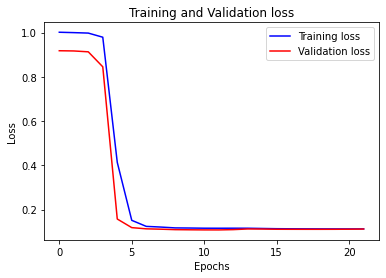

In [14]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
visualize_loss(history, "Training and Validation loss")

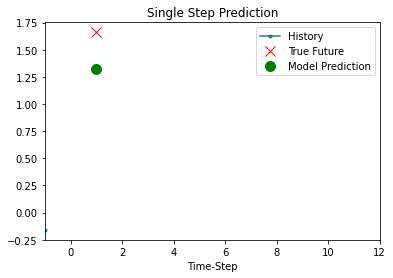

In [15]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

for x, y in dataset_val.take(1):
    show_plot(
        [x[0][:, 0].numpy(), y[0].numpy(), model.predict(x)[0]],
        1,
        "Single Step Prediction",
    )

In [16]:
def denormalize(value):
    data_mean = mean[len(titles)-1]
    data_std = std[len(titles)-1]
    return value*data_std+data_mean

for x, y in dataset_val.take(10):
    predictionData = model.predict(x)
    denormalized_predictionData = denormalize(predictionData)[0]
    actualValue = y[0].numpy()
    print("predicted denormalized:", denormalized_predictionData)
    print("   actual denormalized:", denormalize(actualValue))
    print("             predicted:", predictionData[0])
    print("                actual:", actualValue)

# for x, y in datasetPredTest.take(1):
#     show_plot(
#         [x[0][:, 0].numpy(), y[0].numpy(), model.predict(x)[0]],
#         1,
#         "Single Step Prediction",
#     )

predicted denormalized: [4098.9497]
   actual denormalized: [4449.]
             predicted: [1.3196734]
                actual: [1.66090371]
predicted denormalized: [4155.174]
   actual denormalized: [3464.]
             predicted: [1.374481]
                actual: [0.70072195]
predicted denormalized: [2467.9429]
   actual denormalized: [2795.]
             predicted: [-0.2702384]
                actual: [0.04857819]
predicted denormalized: [1724.3976]
   actual denormalized: [1762.]
             predicted: [-0.99504924]
                actual: [-0.95839415]
predicted denormalized: [2563.225]
   actual denormalized: [2605.]
             predicted: [-0.17735696]
                actual: [-0.13663453]
predicted denormalized: [1758.3123]
   actual denormalized: [1744.]
             predicted: [-0.96198916]
                actual: [-0.97594062]
predicted denormalized: [3455.051]
   actual denormalized: [3275.]
             predicted: [0.69199836]
                actual: [0.51648402]
predic

In [23]:
def normalize(data):
    return (data - mean) / std

predTest = pd.read_csv('../data/test_val.csv',',')
mean = train[titles].values.mean(axis=0)
std = train[titles].values.std(axis=0)
featuresPredTest = predTest[titles]
predTestRange = int(featuresPredTest.shape[0])
featuresPredTest = normalize(featuresPredTest.values)
featuresPredTest = pd.DataFrame(featuresPredTest)
x_predTest = featuresPredTest[[i for i in range(10)]].values
y_predTest = featuresPredTest.iloc[0:][[10]]

datasetPredTest = keras.preprocessing.timeseries_dataset_from_array(
    x_predTest,
    y_predTest,
    sequence_length=1,
    sampling_rate=1,
    batch_size=1
)

for x, y in datasetPredTest.take(10):
    predictionData = model.predict(x)
    denormalized_predictionData = denormalize(predictionData)
    print("predicted denormalized:", denormalized_predictionData)
    print("   actual denormalized:", denormalize(y[0].numpy()))
    print("             predicted:", predictionData)
    print("                actual:", y[0].numpy())

predicted denormalized: [[2462.231]]
   actual denormalized: [2357.]
             predicted: [[-0.27156138]]
                actual: [-0.37541388]
predicted denormalized: [[2453.9917]]
   actual denormalized: [2566.]
             predicted: [[-0.27969265]]
                actual: [-0.16915142]
predicted denormalized: [[3533.457]]
   actual denormalized: [3230.]
             predicted: [[0.7856337]]
                actual: [0.48615135]
predicted denormalized: [[3177.319]]
   actual denormalized: [2681.]
             predicted: [[0.4341604]]
                actual: [-0.05565771]
predicted denormalized: [[1826.1156]]
   actual denormalized: [1748.]
             predicted: [[-0.8993447]]
                actual: [-0.97643705]
predicted denormalized: [[1855.8901]]
   actual denormalized: [2064.]
             predicted: [[-0.86996007]]
                actual: [-0.6645761]
predicted denormalized: [[2340.3345]]
   actual denormalized: [2810.]
             predicted: [[-0.39186132]]
            

In [ ]:
# for x,y in datasetPredTest.take(2):
#     print(x[0][0].numpy(
normalize(featuresPredTest.values)

In [24]:
cc=denormalize(0.4095)
cc2=denormalize(0)
print(cc, cc2)
print(cc2 - cc)

3169.671454078709 2762.383514099783
-407.2879399789258


In [ ]:
x_train

In [ ]:
x_train.shape

In [ ]:
y_train

In [ ]:
y_train.shape

In [ ]:
mean

In [ ]:
std

In [ ]:
train[titles].values.mean(axis=0)

In [ ]:
test = [[[3.96250010e+00, 5.92916600e+07, 7.00000000e+00, 7.00000000e+00, 4.53000021e+00, 1.08999996e+01, 1.99000000e+02, 2.00000000e+01, 4.00000000e+00, 0.00000000e+00]]]

In [ ]:
test

In [ ]:
(test-train[titles].values.mean(axis=0))/train[titles].values.std(axis=0)

In [17]:
train[titles].values.mean(axis=0)

array([-1.75083294e+03,  2.00750551e+02,  1.66239649e+09,  1.19796115e+01,
        1.91216897e+00,  4.49067901e+00,  9.55689590e+00,  2.18859067e+02,
        2.18968203e+01,  4.37936406e+00,  2.73739641e+03])

In [18]:
train[titles].values.std(axis=0)

array([1.83037727e+02, 9.15228348e+01, 7.60116407e+08, 3.36948488e+00,
       1.38422981e+00, 1.60899072e+00, 2.72736533e+00, 7.63923341e+01,
       7.56692744e+00, 1.51338549e+00, 1.01327208e+03])

In [ ]:
targets

In [ ]:
train_data.shape

In [14]:
y_val.values

array([[ 1.18080767],
       [ 0.19404747],
       [ 0.36203571],
       ...,
       [-0.93475157],
       [-0.51751248],
       [-0.90675353]])

In [13]:
x_val.shape

(52895, 7)